# EMC Final Project

In [1]:
import matplotlib.pyplot as plt
from brian2 import *

%matplotlib inline

First let's describe the dynamics of the saturating synapse model (since it's simpler):

$$
\begin{eqnarray}
s_n(t)       &=& \sum_{t_n} \delta ( t - t_n) \\
\dot{r_n}(t) &=& -\lambda_s r_n(t) + s_n(t) \\
\dot{V_n}(t) &=& -\lambda_V V_n(t) + \sum_{m=1}^T A_{nm} \tanh{(\gamma r_m(t))} + V_r \lambda_s r_n(t) - \theta s_n(t) + I_{e,n}(t) \\
\end{eqnarray}
$$

Next, let's describe each of the various parameters and variables necessary to implement the model:

* Incoming spiketrain, $s(t)$
    * Just a train of delta impulses - no parameters needed.
    * Simply increment on-spike with Brian2
* Normalized synaptic current, $r(t)$
    * $\lambda_s = \tau_s^{-1}$ : time constant of synaptic decay (consistent for all synapses in this model)
* Membrane potential, $V(t)$
    * $\lambda_V = \tau_m^{-1}$ : membrane time constant for neuron
    * $A_{nm}$  : maximum synapse strength from neuron `m` to neuron `n`
    * $\gamma$  : "fraction of synaptic resources consumed" by the synapse
    * $V_r$     : resting voltage (temporally integrated size of afterdepolarization recovery current)
    * $\theta$  : threshold voltage (compared to reset voltage)
    * $I_{e,n}$ : external input current
    
Now, let's set some of those parameters as defined in the paper and supplemental materials.

In [2]:
lambda_s = 1/(100 * ms)
lambda_v = 1/(1 * second)

theta = 0.1
gamma = 0.05
V_r = 0.9 * theta

Now, we'll define the differential equations for Brian2 to implement in the model.

In [3]:
eqsNeuSat = '''
dV/dt = -lambda_v * V + Hz*satsyn + V_r * lambda_s * r  + Hz*(Iext + Ifb) : 1
satsyn : 1 # saturation synapse summation term
Iext : 1 # input current
Ifb : 1 # feedback current

dr/dt = -lambda_s * r : 1
'''
#resetSat = 'V -= theta'
resetSat = 'V = 0'
threshSat = 'V > theta'
eqsSynSat = '''
A : 1 # maximum synaptic weight
wf : 1 # feedback weights
satsyn_post = A * tanh(gamma * r_pre) : 1 (summed)
plastic : boolean (shared)
'''
eqsPreSat = 'r += 1'

In [4]:
N = 50
g = 1.5
p = 0.1

In [5]:
start_scope()

resevoir = NeuronGroup(N, eqsNeuSat, threshold=threshSat, reset=resetSat, method='euler')
resevoir.V = V_r

# check_neur.Iext = 250*sin(4*pi*Hz*t)
satSyn = Synapses(resevoir, resevoir, eqsSynSat, on_pre=eqsPreSat)
satSyn.connect(p=p)
satSyn.A = g**2/(N*p) * randn(satSyn.N[:])

Let's view the synaptic connections within the resevoir to make sure we've implemented them correctly; they should be randomly dispersed, with random weights (represented via dot size, scaled to be easily distinguished).

WARNING    /opt/conda/lib/python3.7/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
 [py.warnings]


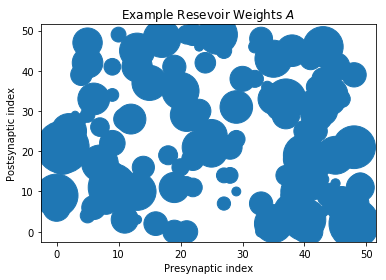

In [6]:
scatter(satSyn.i,satSyn.j,s=satSyn.A*2000)
xlabel('Presynaptic index')
ylabel('Postsynaptic index')
title('Example Resevoir Weights $A$')
show()

Now, let's define the output summation to find $z = w^o\tilde{r}$. Equation 13 defines this output as $$z_k(t) = \sum_{m=1}^N w_{km}^o \tanh{(\gamma r_m(t))}$$ where $k$ represents the dimensionality of the output (here we'll assume 1-dimensional) and $w_{km}^o$ the learnable synaptic output weights. In Brian, there are a few ways that we could implement this, but to best separate out training/testing and keep things as changeable as possible, we'll implement the output as a pseudo-neuron (i.e. a non-spiking neuron that simply sums the weights).

First, we'll consider the situation where there is no feedback (cf. Fig 2a).

----

Output weights are updated via Recursive Least Squares (RLS) and FORCE algorithms; see [Sussillo and Abbott, 2009](https://doi.org/10.1016/j.neuron.2009.07.018) and [2012](https://doi.org/10.1371/journal.pone.0037372) for development and explanation. Simply, we update a running filter estimate of the inverse correlation matrix $P$ by the update scheme $$P(t) = P(t - \Delta t) - \frac{P(t - \Delta t) \tilde{r}(t) \tilde{r}(t)' P(t - \Delta t)'}{1 + \tilde{r}(t)' P(t - \Delta t) \tilde{r}(t)}$$ or, more simply, $$P(t) = P(t - \Delta t) - \frac{k k'}{1 + \tilde{r}(t)' k}$$ where $k = P(t - \Delta t) \tilde{r}(t)$ and $\tilde{r}(t) =  \tanh{(\gamma r(t))}$.

This running filter estimate is used to update the output weights based on the current training error $e(t) = z(t) - F(t)$ (recall that we assume $k=1$). Here, the output signal $z(t)$ should track the target signal $F(t)$ as closely as possible. The output weights $w_m^o$ are then updated with the equation,
$$w_{\beta}^o(t) = w_{\beta}^o(t - \Delta t) - e(t) \sum_{\rho} P_{\beta \rho}(t)\tilde{r}_{\rho}(t)$$
where indices $\beta$ and $\rho$ are the range of all synapses ($\beta, \rho = 1,...,N$).

In [7]:
inneur = NeuronGroup(1,model='F = -1.5*sin(14*pi*Hz*t) + 1*cos(28*pi*Hz*t) : 1')#,events={'custom_event': 't>0*second'})
insyn = Synapses(inneur, resevoir,
                model='''wi:1 # fixed input weights
                         Iext_post = wi * F_pre : 1 (summed)
                         ''')
#insyn = Synapses(inneur, resevoir,model='wi:1',on_pre='Iext += wi*F_pre',on_event={'pre': 'custom_event'})
insyn.connect()
insyn.wi = '2*rand() - 1'

In [8]:
outneur = NeuronGroup(1,model='z : 1',events={'custom_event': 't>0*second'})

outsyn = Synapses(resevoir, outneur,
                 model='''wo : 1 # learnable output weights
                          rtilde = tanh(gamma * r_pre) : 1
                          z_post = wo * rtilde : 1 (summed)
                          plastic : boolean (shared)
                          ''')
outsyn.connect()
outsyn.wo = 0

In [9]:
feedback = Synapses(outneur, resevoir,
#                    model='''wf:1 # idk'
#                             Ifb_post = wf * z_pre : 1''')
                    model='wf:1',on_pre='Ifb = wf * z_pre', on_event={'pre': 'custom_event'})
feedback.connect()
feedback.wf = '2*rand() - 1'

In [10]:
synmon = StateMonitor(outsyn,['wo'],record=True)
outmon = StateMonitor(outneur,'z',record=True)
inmon = StateMonitor(inneur, 'F',record=True)
checkMon = SpikeMonitor(resevoir)
checkState = StateMonitor(resevoir,['V', 'r', 'Iext'], record=True)

In [11]:
alpha = 3
P = zeros([N,N]) + eye(N)*alpha**-1

@network_operation()
def update_wo():
    global P
    if not any(outsyn.plastic):
        return
    e = outneur.z - inneur.F
    rtilde = tanh(gamma * numpy.asarray(resevoir.r))
    k = P * rtilde
    c = 1.0/(1.0 + rtilde.T*k)
    P = P - k*(k.T * c)
    w_update = e * P * rtilde
    outsyn.wo = outsyn.wo - sum(w_update, axis=0)
    
@network_operation()
def update_A():
    global P
    if not any(satSyn.plastic):
        return
    
    e = outneur.z - inneur.F
    rtilde = tanh(gamma * numpy.asarray(resevoir.r))
    A_update = satSyn.wf * e * P * rtilde
    satSyn.A = satSyn.A - A_update.flatten()

In [12]:
store('initialized')

In [13]:
restore('initialized')
outsyn.plastic = True
satSyn.plastic = False

In [14]:
run(300*ms)
store('after_training')

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "Ifb = wf * z_pre"
 [brian2.codegen.generators.base]


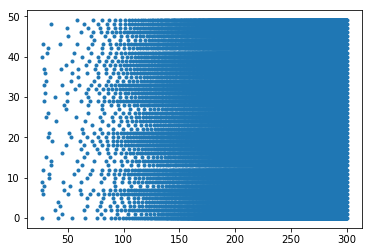

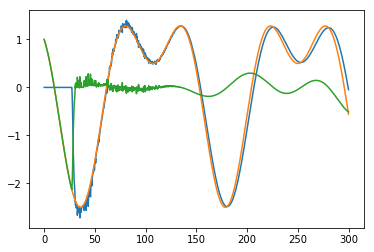

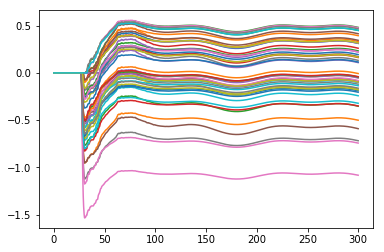

In [15]:
#for i in range(N):
#    plot(checkState.t/ms, checkState.Iext[i])
#show()
#plot(checkState.t/ms, checkState.V[0])
#show()
plot(checkMon.t/ms, checkMon.i,'.')
show()
plot(outmon.t/ms, outmon.z.flatten())
plot(inmon.t/ms, inmon.F.flatten())
plot(inmon.t/ms, inmon.F.flatten() - outmon.z.flatten())
show()
for i in range(N):
    plot(synmon.t/ms,synmon.wo[i])
show()

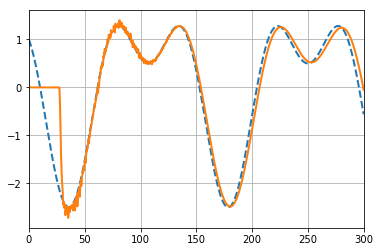

In [16]:
plot(inmon.t/ms, inmon.F.flatten(),ls='--',lw=2)
plot(outmon.t/ms, outmon.z.flatten(),lw=2)
xlim([0,300])
grid()
show()

In [17]:
restore('after_training')

In [18]:
#insyn.wi = 0
outsyn.plastic = False
run(100*ms)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "Ifb = wf * z_pre"
 [brian2.codegen.generators.base]


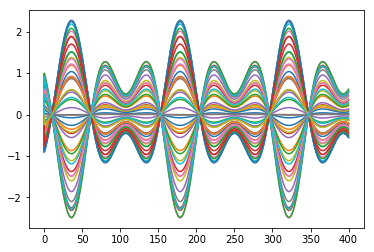

In [19]:
for i in range(N):
    plot(checkState.t/ms, checkState.Iext[i])
show()

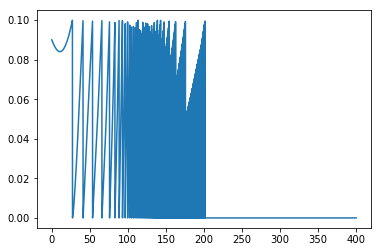

In [20]:
plot(checkState.t/ms, checkState.V[0])
show()

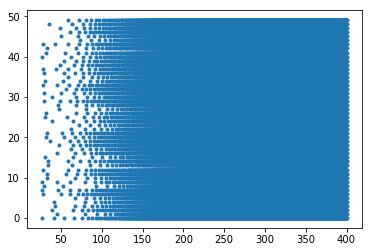

In [21]:
plot(checkMon.t/ms, checkMon.i,'.')
show()

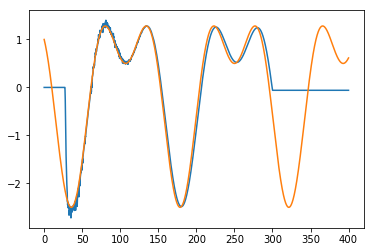

In [22]:
plot(outmon.t/ms, outmon.z.flatten())
plot(inmon.t/ms, inmon.F.flatten())
show()

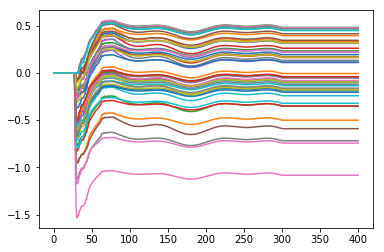

In [23]:
for i in range(N):
    plot(synmon.t/ms,synmon.wo[i])
show()